# Recitation 11: Column generation and vehicle routing

Today we will spend some time thinking about and implementing column generation, in the particular context of vehicle routing problems.

- dual fbility determines primal optimality 
- check if for all i,  y'A_i < c_i (equivalent way of verifying there exists no unexplored improvements is to solve subproblem)
- only work if we could write in certain form that prevents us from enumerating every integer solution within (e.g. knapsack) - easier P represenetation
- ovrp doesn't have vehicle cstr but cvrp has (R is humongous); but ovrp encodes this implicitly (perhaps crxr)
- READ DUAL cstr for reduced cost: sol is fbl for all dual cstr (cr - gamma pi)
- w_ij represents one route, master problem has route and new coefficients appear, 
- subproblem is selecting the path  (most negative cost!= reduced cost)
- cost becomes the distance and finding the most negative reduced cost problem becomes finding a path with shortest added cost, and that cost is modified with p (I don't know what's the intuition for modifying cost is); 
- cost = distance; most negative reduced cost = most shortest path (c12 - lambda12)
- find subtour is the key: over all sets of a customer - callback function

- p is dual variable, computed right after we solve master, 
- w_ij
- for upper bound, what's fbl for the lower on is fbl for the previous one
- lower bound is weak 
- intuition for p + adjusted value
- add cstr to our (what is valid route in the first place - capacity,  new_route_cap) 
- restricts the route: some vehicles whwere foute is chosen one time, (half vehicle col gen is problem - lp relx of master - solve is - restore )
- price and branch

1. master prob is not IP?
2. before and after primal fbl remains?

In [12]:
using Plots, Random, LinearAlgebra, Printf, JLD, Distributions, Combinatorics, Graphs

ArgumentError: ArgumentError: Package Graphs not found in current path.
- Run `import Pkg; Pkg.add("Graphs")` to install the Graphs package.

In [11]:
using JuMP, Gurobi

const GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18


Gurobi.Env(Ptr{Nothing} @0x000000016fb6aa00, false, 0)

## 1 - Vehicle routing problems

In an earlier recitation, we talked about the traveling salesman problem (TSP), where the goal is to find a minimum-length tour visiting a set of locations. The TSP has many "cousins", i.e., similar problems with additional complexity to represent practical considerations. One family of such problems are called vehicle routing problems (VRP), and seek to find the optimal set of routes for a *fleet* of vehicles to service a set of customers.

Some examples include:
- Open vehicle routing problem (OVRP): we are given a set of customers that must each be visited exactly once by some vehicle. All routes start from a customer location and must end at a single location, called the "depot". An example of an application of this setting is car-pooling.
- Capacitated vehicle routing problem (CVRP): in this setting, routes must begin and end at the depot, and each customer $i$ is now associated with a demand $d_i$, such that the total demand along any route cannot excced the vehicle capacity $Q$. This is a simplified version of the problem many delivery services face.


## 2 - Solving OVRP using column generation

Let's generate a problem instance, with $N$ locations uniformly sampled from a square (side length $L$) 

In [6]:
struct VehicleRoutingData
    capacity::Int
    num_vehicles::Int
    num_customers::Int
    distances::Matrix{Float64}
    locations::Matrix{Float64}
    demand::Vector{Float64}
end


In [7]:
data = load("data.jld", "data")

UndefVarError: UndefVarError: load not defined

Let's plot this example to get a sense of what it looks like!

In [8]:
function plot_from_data(
    data::VehicleRoutingData,
)
    """Given a problem instance, plot it.
    """
    N = data.num_customers
    pl = plot(
        size = (500,500), 
        xlim = (0, 100), 
        ylim = (0, 100),
    )
    for i in 1:N
        annotate!(
            data.locations[i,1] + 3, 
            data.locations[i,2] + 3, 
            text("$i")
        )
    end
    scatter!(
        data.locations[1:N, 1], 
        data.locations[1:N, 2], 
        label = "Customers",
    )
    scatter!(
        data.locations[[N+1], 1], 
        data.locations[[N+1], 2], 
        label = "Depot"
    )
    scatter!(
        legend = :left,
    )
    return pl
end
plot_from_data(data)

UndefVarError: UndefVarError: data not defined

Now we need to formulate the problem. 

Setup:
- Let $\mathcal{R}$ designate the set of ALL possible routes starting at some customer and ending at the depot.
- Let $c_r$ designate the length of route $r\in\mathcal{R}$.
- Let $\gamma_{i,r}$ denote if customer $i \in \mathcal{N}_C$ is visited by route $r$.

Then we can formulate OVRP as the following set partitioning problem:

\begin{align}
    \min \quad 
    & \sum_{r\in\mathcal{R}} c_r x_r
    \\
    \text{s.t.} \quad 
    & \sum_{r\in\mathcal{R}} \gamma_{i,r} x_r = 1 
    && \forall i \in \mathcal{N}_C 
    \\
    & x_r \in \{0,1\} 
    && \forall r \in \mathcal{R}
\end{align}


This formulation is so simple! But of course, the complexity is "hidden" in the exponential size of the set $\mathcal{R}$. In fact, we cannot hope to formulate this problem explicitly as written.

However, most routes in the set $\mathcal{R}$ are useless! For example, consider a random route:

In [20]:
N = data.num_customers
nodes = vcat(N+1, shuffle(1:N)[1:4], N+1)

6-element Vector{Int64}:
 11
  8
  1
  3
  4
 11

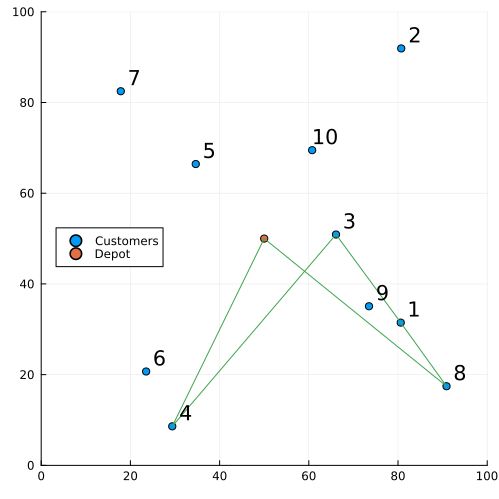

In [21]:
pl = plot_from_data(data)
plot!(data.locations[nodes, 1], data.locations[nodes, 2], label="")

So clearly, we can get a good solution (maybe even an optimal one!) to the problem with a restricted set of routes.

Let's consider the linear relaxation of the problem, denoted by (P):

\begin{align*}
    \tag{P}
    \min \quad 
    & \sum_{r\in\mathcal{R}} c_r x_r
    \\
    \text{s.t.} \quad 
    & \sum_{r\in\mathcal{R}} \gamma_{i,r} x_r = 1 
    && \forall i \in \mathcal{N}_C 
    \\
    & x_r \geq 0
    && \forall r \in \mathcal{R}
\end{align*}

Notice that we've eliminated the upper bounds on $x_r$. It doesn't break the validity of the formulation, because from any solution with $x_r>1$, we can construct a feasible solution with $x_r'=1$ which lowers the total cost by $c_r (x_r-1)$.



Now we can write down the dual, with dual variables $p_i$, denoted by (D):
$$
\begin{align*}
    \tag{D}
    \max \quad 
    & \sum_{i=1}^N p_i
    \\
    \text{s.t.} \quad 
    & \sum_{i \in \mathcal{N}_C} \gamma_{i,r} p_i \leq c_r 
    && \forall r\in\mathcal{R} 
    \\
    & p_i \in \mathbb{R} 
    && \forall i\in \mathcal{N}_C
\end{align*}
$$



Assume we solve the main problem with a restricted set of routes  $\mathcal{R}^k\subset\mathcal{R}$, and we get a primal feasible solution $y^k$, and a dual solution $p^k$. The solution $y^k$ is optimal in the full primal if the corresponding dual solution $p^k$ is feasible in the full dual.

For dual feasibility, we require that $\sum_{i \in \mathcal{N}_C} \gamma_{i,r} p_i \leq c_r $ for **every** route $r\in\mathcal{R}$. We can re-write this requirement as $c_r - \sum_{i \in \mathcal{N}_C} \gamma_{i,r} p_i \geq 0$. In other words, the **reduced cost** of each variable $y_r$ must be nonnegative.

So we propose the following column generation algorithm:
1. Solve (P) over a restricted set of routes $\mathcal{R}^k$, obtain a primal solution $y^k$ and a dual solution $p^k$
2. Find the route $r$ with the smallest reduced cost $\bar{c} = c_r - \sum_{i \in \mathcal{N}_C} \gamma_{i,r} p^k_i$
3. If $\bar{c}\ge 0$, terminate. Otherwise add the corresponding $r$ to $\mathcal{R}^k$ (obtaining $\mathcal{R}^{k+1}$) and iterate.

Let's start implementing this algorithm! First, we need an initial set of routes that will produce a feasible primal solution. An easy place to start is to just have each customer in its own route.

In [23]:
struct Route
    arcs::Vector{Tuple{Int,Int}}
    cost::Float64
    customers::Vector{Int}
end

In [35]:
function compute_route_cost(
    data::VehicleRoutingData,
    arcs::Vector{Tuple{Int,Int}},
)
    return sum(data.distances[arc...] for arc in arcs)
end

compute_route_cost (generic function with 1 method)

In [53]:
function initial_routes(
    data::VehicleRoutingData
    ;
)
    """
    Given a problem instance, generates a feasible set of routes.
    Puts each customer in their own route.
    """
    N = data.num_customers
    routes = Route[]
    for i in 1:N
        arcs = [(N+1, i), (i, N+1)]
        push!(routes, Route(
                arcs,
                compute_route_cost(data, arcs),
                [i],
            )
        )
    end
    return routes
end

initial_routes (generic function with 1 method)

In [54]:
initial_routes(data)

10-element Vector{Route}:
 Route([(11, 1), (1, 11)], 71.56680064087928, [1])
 Route([(11, 2), (2, 11)], 103.94564968204517, [2])
 Route([(11, 3), (3, 11)], 32.243335821418995, [3])
 Route([(11, 4), (4, 11)], 92.49012368117184, [4])
 Route([(11, 5), (5, 11)], 44.97027208973959, [5])
 Route([(11, 6), (6, 11)], 78.98712444743651, [6])
 Route([(11, 7), (7, 11)], 91.41624583674238, [7])
 Route([(11, 8), (8, 11)], 104.50648896213195, [8])
 Route([(11, 9), (9, 11)], 55.66886038461124, [9])
 Route([(11, 10), (10, 11)], 44.517412549495354, [10])

Next, we need a way to compute route with the smallest reduced cost: 
$$
\begin{equation}
    \min_{r \in \mathcal{R}} 
    \left\{ 
        \overline{c}_r = c_r - \sum_{i \in \mathcal{N}_C} \gamma_{i,r} p_i 
    \right\}
\end{equation}
$$

For specific values of $p$, this can be solved as a **shortest-path problem**. The idea is that we can decompose the reduced cost of a route as the sum of costs of arcs on a **modified network**. In this case, our modified network has the following arc costs:
$$
\begin{align*}
    \tilde{c}_{i,j} = \begin{cases}
        c_{i,j} - p_j & \text{ if $j \in \mathcal{N}_C$} \\
        c_{i,j} & \text{ otherwise.}
    \end{cases}
\end{align*}
$$

We can then solve the shortest-path problem via the following optimization problem over the variables $w_{i,j}$ (denoting if arc $(i,j)$ is in the route, for $i, j \in \mathcal{N}$). The formulation is:
$$
\begin{align*}
    \min \quad 
    & \sum_{i \in \mathcal{N}} \sum_{j \in \mathcal{N}}
    \tilde{c}_{i,j} w_{i,j}
    \\
    \text{s.t.} \quad 
    & \sum_{j \in \mathcal{N}_C} w_{N+1,j} = 1
    \\
    & w_{i,i} = 0
    &\quad& \forall \ i \in \mathcal{N}
    \\
    & \sum_{j \in \mathcal{N}} w_{i,j} 
    = \sum_{j \in \mathcal{N}} w_{j,i}
    &\quad& \forall \ i \in \mathcal{N}
    \\
    & \sum_{j \in \mathcal{N}} w_{i,j} \leq 1
    &\quad& \forall \ i \in \mathcal{N}
    \\
    & \sum_{i \in S} \sum_{j \in S} w_{i,j} \leq |S| - 1
    &\quad& \forall \ S \subseteq \mathcal{N}_C
    \\
    & w_{i,j} \in \{0, 1\} 
    && \forall \ i, j \in \mathcal{N}
\end{align*}
$$

The first constraint requires a route to leave the depot, the second removes self-arcs, the third is flow conservation, the fourth bounds the flow at each customer above by 1, and the fifth constraint eliminates subtours which do not include the depot.

We implement this in the function `new_route()` below. Note that we had to use lazy callbacks to deal with the exponential number of subtour elimination constraints in the formulation.

In [64]:
function find_subtours(
    N::Int,
    sol::Array{Float64, 2},
)
    """
    Given a solution (provided as a N+1 by N+1 array,
    with `sol[i,j] == 1.0` whenever the arc `i->j` is in the route),
    produces a list of components (as a Vector{Vector{Int}}) 
    where each component consists of the nodes that are "connected".
    """
    @assert size(sol) == (N+1, N+1)
    g = DiGraph(N+1)
    for ind in findall(x -> (x > 0.5), sol)
        add_edge!(g, ind[1], ind[2])
    end
    components = strongly_connected_components(g)

    ind = findfirst(x -> (N+1 in x), components)
    subtour = popat!(components, ind)
    i = findfirst(x -> x == N+1, subtour)
    new_subtour = vcat(subtour[i:end], subtour[1:i-1])
    insert!(components, 1, new_subtour)

    return components
end

find_subtours (generic function with 1 method)

In [65]:
function compute_route_reduced_cost(
    data::VehicleRoutingData,
    route::Route,
    p::Vector{Float64}, 
)
    """
    Computes reduced cost of a route according to dual variables p and q.
    """
    N = data.num_customers
    return (
        compute_route_cost(data, route.arcs) #c_ij
        - sum(p[i] for i in 1:N if i in route.customers) #p_i
    )
end

compute_route_reduced_cost (generic function with 1 method)

In [100]:
function new_route(
    data::VehicleRoutingData,
    p::Vector{Float64},
)
    """
    Given dual variables p, 
    find a new route to add with minimum reduced cost.
    """

    N = data.num_customers
    
    # Compute arc costs of the modified network, c̃ 
    modified_costs = copy(data.distances)
    for i in 1:N
        modified_costs[i,:] = modified_costs[i,:] .- p[i] #(1,0,1)y_ij, a_ip indep?
    end

    # Create subproblem model
    sp_model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        sp_model,
        "OutputFlag" => 0,
    )
    @variable(sp_model, w[i in 1:N+1, j in 1:N+1], Bin) # whether arc (i, j) is selected
    @variable(sp_model, v[i in 1:N], Bin) # whether the route starts from i

    # Flow conservation constraints
    @constraint(
        sp_model,
        [i in 1:N],
        sum(w[j,i] for j in 1:N+1) + v[i]
        == sum(w[i,j] for j in 1:N+1) 
    )
    @constraint(
        sp_model,
        [i in 1:N],
        sum(w[i,j] for j in 1:N+1) 
        ≤ 1
    )
    @constraint(
        sp_model,
        [i in 1:N+1],
        w[i,i] == 0 
    )
    @constraint(
        sp_model,
        sum(w[j,N+1] for j in 1:N+1) == 1
    )
    @constraint(
        sp_model,
        sum(w[N+1,j] for j in 1:N+1) == 0
    )

    # Objective: minimizing sum of modified costs of selected arcs 
    @objective(
        sp_model,
        Min,
        sum(
            modified_costs[i,j] * w[i,j]
            for i in 1:N+1, j in 1:N+1
        )
    )

    # Callback function to eliminate subtours
    # Uses the helper function `find_subtours`.
    function eliminate_subtours(cb_data)
        status = callback_node_status(cb_data, sp_model)
        if status == MOI.CALLBACK_NODE_STATUS_FRACTIONAL
            return
        elseif status == MOI.CALLBACK_NODE_STATUS_INTEGER
            sol = callback_value.(cb_data, w)
            subtours = find_subtours(N, sol)
            for subtour in subtours
                if length(subtour) == 1 || N+1 in subtour
                    continue
                else
                    cut = @build_constraint(
                        sum(w[i,j] for i in subtour, j in subtour)
                        ≤ length(subtour) - 1
                    )
                    MOI.submit(sp_model, MOI.LazyConstraint(cb_data), cut)
                end
            end
        end
    end
    MOI.set(sp_model, MOI.LazyConstraintCallback(), eliminate_subtours)

    optimize!(sp_model)

    # Compute route from solution
    sol = value.(w)
    nodes = [argmax(value.(v))]
    while nodes[end] != N+1
        push!(nodes, argmax(sol[nodes[end],:]))
    end

    arcs = collect(zip(nodes[1:end-1], nodes[2:end]))
    route = Route(
        arcs,
        compute_route_cost(data, arcs),
        nodes[1:end-1],
    )
    reduced_cost = compute_route_reduced_cost(data, route, p)

    return route, reduced_cost

end

new_route (generic function with 1 method)

Whew! We implemented the subproblem, which was not easy. Now, the main problem should be a piece of cake!

In [101]:
function ovrp(
    data::VehicleRoutingData,
    ;
    max_iterations::Int = 10000,
    verbose::Bool = true,
)
    """
    Column generation algorithm for the VRP.
    """
    N = data.num_customers

    # Initialization
    CGLP_solution = nothing
    CGLP_objective = 0.0
    p_values = []

    # Creates initial routes
    routes = initial_routes(data)
    counter = 0

    while true
        counter += 1

        # Make restricted master problem with current routes 
        MP_start_time = time()
        model = Model(() -> Gurobi.Optimizer(GRB_ENV))
        set_optimizer_attributes(
            model,
            "OutputFlag" => 0,
        )
        @variable(model, x[r in 1:length(routes)] ≥ 0)
        @constraint(
            model,
            visit_customer[i in 1:N], 
            sum(
                x[r] for r in 1:length(routes)
                if i in routes[r].customers
            ) == 1
        )
        @objective(
            model, 
            Min,
            sum(x[r] * routes[r].cost for r in 1:length(routes))
        )
        optimize!(model)
        MP_end_time = time() 

        # Get dual values
        p = dual.(visit_customer)
        push!(p_values, p)

        # Compute a new route to add and its corresponding reduced cost
        route, reduced_cost = new_route(data, p)

        if verbose
            @printf(
                "Iteration %3d | Reduced cost: %12.3f\n",
                counter, 
                reduced_cost,
            )
        end

        # Termination criteria
        if (
            reduced_cost > -1e-6
            || counter > max_iterations
        )  
            CGLP_solution = value.(x)
            CGLP_objective = objective_value(model)
            break
        end
        push!(routes, route)
    end

    return Dict(
        "CGLP_solution" => CGLP_solution,
        "CGLP_objective" => CGLP_objective,
        "routes" => routes,
        "p_values" => p_values,
    )
end

ovrp (generic function with 1 method)

Now, let's try to solve the problem, and look at the solution we obtain!

In [133]:
ovrp_solution = ovrp(data)

Iteration   1 | Reduced cost:     -444.784
Iteration   2 | Reduced cost:     -373.816
Iteration   3 | Reduced cost:     -336.433
Iteration   4 | Reduced cost:     -106.935
Iteration   5 | Reduced cost:      -98.519
Iteration   6 | Reduced cost:     -114.294
Iteration   7 | Reduced cost:     -122.913
Iteration   8 | Reduced cost:      -55.459
Iteration   9 | Reduced cost:      -73.017
Iteration  10 | Reduced cost:      -68.673
Iteration  11 | Reduced cost:      -55.046
Iteration  12 | Reduced cost:      -62.832
Iteration  13 | Reduced cost:      -82.215
Iteration  14 | Reduced cost:      -70.005
Iteration  15 | Reduced cost:      -62.401
Iteration  16 | Reduced cost:      -40.685
Iteration  17 | Reduced cost:      -38.021
Iteration  18 | Reduced cost:      -76.071
Iteration  19 | Reduced cost:      -51.840
Iteration  20 | Reduced cost:      -43.190
Iteration  21 | Reduced cost:      -30.129
Iteration  22 | Reduced cost:      -34.682
Iteration  23 | Reduced cost:      -47.217
Iteration  

Dict{String, Any} with 4 entries:
  "CGLP_solution"  => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0…
  "routes"         => Route[Route([(11, 1), (1, 11)], 71.5668, [1]), Route([(11…
  "CGLP_objective" => 209.883
  "p_values"       => Any[[71.5668, 103.946, 32.2433, 92.4901, 44.9703, 78.9871…

In [58]:
function plot_from_route_solution(
    data::VehicleRoutingData,
    routes::Vector{Route},
    solution::Vector{Float64},
)
    """Given a problem instance and a corresponding route solution, plot it.
    """
    N = data.num_customers
    pl = plot_from_data(data)
    k = 0
    for (route, val) in zip(routes, solution)
        if val == 0.0
            continue
        end
        k += 1
        nodes = [arc[1] for arc in route.arcs]
        push!(nodes, N+1)
        plot!(
            data.locations[nodes, 1],
            data.locations[nodes, 2],
            label = "Vehicle $k: $val",
        )
    end
    plot!(title = "Column generation solution")
    return pl
end


plot_from_route_solution (generic function with 1 method)

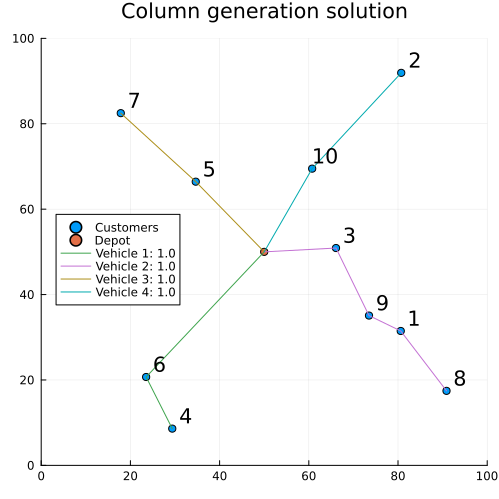

In [134]:
plot_from_route_solution(data, ovrp_solution["routes"], ovrp_solution["CGLP_solution"])

We note that we solve the formulation extremely quickly, and the solution seems reasonable! Let's try on a bigger instance:

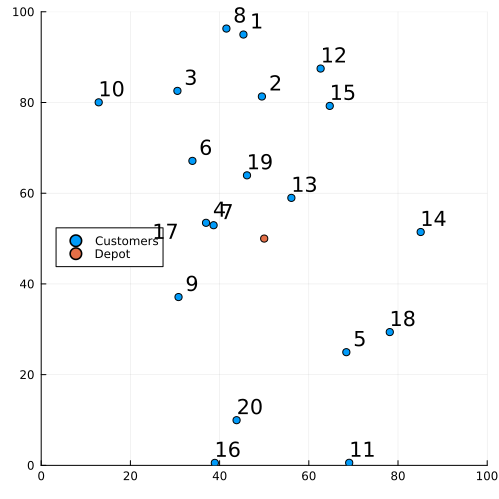

In [135]:
data_large = load("data_large.jld", "data_large")
plot_from_data(data_large)

In [130]:
ovrp_solution_large = ovrp(data_large)

Iteration   1 | Reduced cost:     -981.339
Iteration   2 | Reduced cost:     -892.242
Iteration   3 | Reduced cost:     -815.897
Iteration   4 | Reduced cost:     -797.960
Iteration   5 | Reduced cost:     -188.235
Iteration   6 | Reduced cost:     -173.449
Iteration   7 | Reduced cost:     -133.715
Iteration   8 | Reduced cost:     -132.631
Iteration   9 | Reduced cost:     -129.061
Iteration  10 | Reduced cost:     -107.169
Iteration  11 | Reduced cost:     -132.872
Iteration  12 | Reduced cost:      -86.333
Iteration  13 | Reduced cost:      -97.357
Iteration  14 | Reduced cost:     -148.396
Iteration  15 | Reduced cost:     -123.088
Iteration  16 | Reduced cost:     -117.439
Iteration  17 | Reduced cost:     -122.213
Iteration  18 | Reduced cost:     -117.979
Iteration  19 | Reduced cost:     -139.941
Iteration  20 | Reduced cost:     -112.477
Iteration  21 | Reduced cost:     -149.227
Iteration  22 | Reduced cost:     -112.235
Iteration  23 | Reduced cost:     -115.554
Iteration  

Dict{String, Any} with 4 entries:
  "CGLP_solution"  => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0…
  "routes"         => Route[Route([(21, 1), (1, 21)], 90.4492, [1]), Route([(21…
  "CGLP_objective" => 303.383
  "p_values"       => Any[[90.4492, 62.6541, 75.8653, 26.9921, 62.1776, 47.0101…

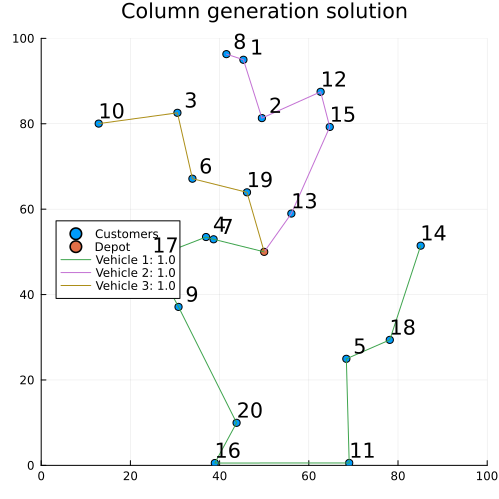

In [132]:
plot_from_route_solution(data_large, ovrp_solution_large["routes"], ovrp_solution_large["CGLP_solution"])

### Monitoring the progress of column generation

That took significantly longer to solve! We'd like more detailed information on what's happening at each iteration of the column generation procedure. To analyze these algorithms, we typically want to report *upper* and *lower* bounds at each iteration, and also how long the master problem and subproblem take to solve.

- **Upper bound:** this part is easy, we just report the objective of our current feasible solution.
- **Lower bound:** this part is trickier. Here, we need to use the fact that in the optimal solution, we will have no more than $N$ routes, so $\sum_{r\in\mathcal{R}}x^*_r \leq N$. Then, given a feasible solution with objective $\text{Obj}$ and the smallest reduced cost $\bar{c}$, the most improvement we can get on $\hat{c}$ is $$\text{Obj} + \sum_{r\in\mathcal{R}}\bar{c}x^*_r \ge \text{Obj} + \bar{c}N$$

(remember $\bar{c}$ is negative!)

In [140]:
function ovrp_progress(
    data::VehicleRoutingData,
    ;
    max_iterations::Int = 10000,
    verbose::Bool = true,
)
    """
    Column generation algorithm for the VRP.
    """
    N = data.num_customers

    # Initialization
    CGLP_solution = nothing
    CGLP_objective = 0.0
    upper_bounds = []
    lower_bounds = []
    MP_time = []
    SP_time = []
    p_values = []

    if verbose
        @printf("              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost\n")
    end

    # Creates initial routes
    routes = initial_routes(data)
    counter = 0

    while true
        counter += 1

        # Make restricted master problem with current routes 
        MP_start_time = time()
        model = Model(() -> Gurobi.Optimizer(GRB_ENV))
        set_optimizer_attributes(
            model,
            "OutputFlag" => 0,
        )
        @variable(model, x[r in 1:length(routes)] ≥ 0)
        @constraint(
            model,
            visit_customer[i in 1:N], 
            sum(
                x[r] for r in 1:length(routes)
                if i in routes[r].customers
            ) == 1
        )
        @objective(
            model, 
            Min,
            sum(x[r] * routes[r].cost for r in 1:length(routes))
        )
        optimize!(model)
        MP_end_time = time() 

        # Get dual values
        p = dual.(visit_customer)
        push!(p_values, p)

        # Update column generation metrics
        push!(upper_bounds, objective_value(model))
        push!(MP_time, MP_end_time - MP_start_time)

        # Compute a new route to add and its corresponding reduced cost
        SP_start_time = time()
        route, reduced_cost = new_route(data, p)
        SP_end_time = time()

        # Update column generation metrics
        push!(lower_bounds, objective_value(model) + N * reduced_cost)
        push!(SP_time, SP_end_time - SP_start_time)

        if verbose
            # @printf("              | Objective | MP time (s) | SP time (s) | Reduced cost")
            @printf(
                "Iteration %3d | %9.3f | %11.3f |      %6.3f |      %6.3f | %12.3f\n",
                counter, 
                upper_bounds[end],
                lower_bounds[end],
                MP_time[end],
                SP_time[end],
                reduced_cost,
            )
        end

        # Termination criteria
        if (
            reduced_cost > -1e-6
            || counter > max_iterations
        )  
            CGLP_solution = value.(x)
            CGLP_objective = objective_value(model)
            break
        end
        push!(routes, route)
    end

    return Dict(
        "CGLP_solution" => CGLP_solution,
        "CGLP_objective" => CGLP_objective,
        "routes" => routes,
        "p_values" => p_values,
        "upper_bounds" => upper_bounds,
        "lower_bounds" => lower_bounds,
        "MP_time" => MP_time,
        "SP_time" => SP_time,
        "time_taken" => sum(MP_time) + sum(SP_time),
    )
end

ovrp_progress (generic function with 1 method)

In [141]:
ovrp_solution_large = ovrp_progress(data_large)

              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost
Iteration   1 |  1298.294 |  -18328.487 |       0.003 |       0.017 |     -981.339
Iteration   2 |   316.955 |  -17527.883 |       0.000 |       0.015 |     -892.242
Iteration   3 |   316.955 |  -16000.995 |       0.001 |       0.034 |     -815.897
Iteration   4 |   316.955 |  -15642.249 |       0.001 |       0.027 |     -797.960
Iteration   5 |   316.955 |   -3447.741 |       0.001 |       0.081 |     -188.235
Iteration   6 |   316.955 |   -3152.032 |       0.000 |       0.055 |     -173.449
Iteration   7 |   316.955 |   -2357.349 |       0.001 |       0.118 |     -133.715
Iteration   8 |   316.955 |   -2335.657 |       0.000 |       0.177 |     -132.631
Iteration   9 |   316.955 |   -2264.263 |       0.000 |       0.062 |     -129.061
Iteration  10 |   316.955 |   -1826.423 |       0.001 |       0.097 |     -107.169
Iteration  11 |   316.955 |   -2340.477 |       0.002 |       0.308 |     -132.872
Iter

Iteration 124 |   305.460 |     -22.068 |       0.002 |       0.048 |      -16.376
Iteration 125 |   305.460 |    -113.125 |       0.006 |       0.140 |      -20.929
Iteration 126 |   305.460 |     -14.198 |       0.002 |       0.063 |      -15.983
Iteration 127 |   305.460 |     123.727 |       0.002 |       0.075 |       -9.087
Iteration 128 |   305.460 |      63.995 |       0.002 |       0.046 |      -12.073
Iteration 129 |   305.460 |       9.259 |       0.002 |       0.090 |      -14.810
Iteration 130 |   305.460 |     -71.874 |       0.001 |       0.044 |      -18.867
Iteration 131 |   305.460 |      23.201 |       0.002 |       0.052 |      -14.113
Iteration 132 |   305.460 |     -70.494 |       0.002 |       0.037 |      -18.798
Iteration 133 |   305.460 |      60.082 |       0.002 |       0.051 |      -12.269
Iteration 134 |   305.460 |      60.082 |       0.002 |       0.059 |      -12.269
Iteration 135 |   305.460 |      60.082 |       0.007 |       0.124 |      -12.269
Iter

Dict{String, Any} with 9 entries:
  "CGLP_solution"  => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0…
  "upper_bounds"   => Any[1298.29, 316.955, 316.955, 316.955, 316.955, 316.955,…
  "routes"         => Route[Route([(21, 1), (1, 21)], 90.4492, [1]), Route([(21…
  "lower_bounds"   => Any[-18328.5, -17527.9, -16001.0, -15642.2, -3447.74, -31…
  "MP_time"        => Any[0.00300002, 0.0, 0.000999928, 0.000999928, 0.00099992…
  "CGLP_objective" => 303.383
  "time_taken"     => 14.752
  "SP_time"        => Any[0.017, 0.0150001, 0.0340002, 0.027, 0.0810001, 0.0550…
  "p_values"       => Any[[90.4492, 62.6541, 75.8653, 26.9921, 62.1776, 47.0101…

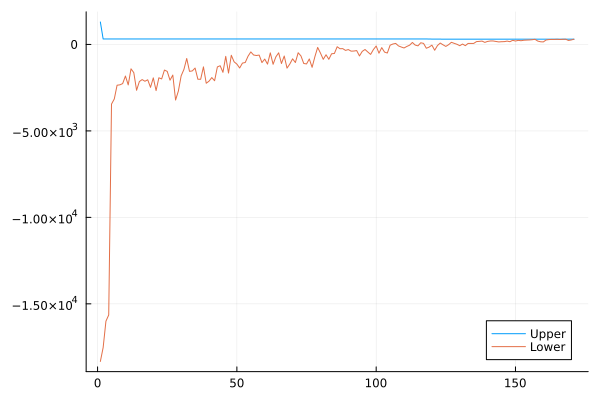

In [144]:
plot(
    1:length(ovrp_solution_large["upper_bounds"]),
    [
        ovrp_solution_large["upper_bounds"],
        ovrp_solution_large["lower_bounds"],
    ],
    legend = :bottomright,
    label = [
        "Upper" "Lower"
    ]
)

## 3 - Solving CVRP using column generation

As we mentioned earlier, OVRP is kind of "easy" and using column generation is probably overkill. But we'll see that we can get a much bigger edge on the harder problem of CVRP.

We're going to consider a super-simple version of CVRP, where each customer has a demand of 1, and the capacity of the vehicle is $Q\ge 1$. (In the homework we will be dealing with the general case.) Our initial routes remain feasible. 

All we need to do is modify the subproblem so that it only finds feasible routes, i.e. routes with less than $Q$ customers, or equivalently, less than $Q$ edges.

In [145]:
function new_route_cap(
    data::VehicleRoutingData,
    p::Vector{Float64},
    Q::Int = length(p),
)
    """
    Given dual variables p, 
    find a new route to add with minimum reduced cost.
    """

    N = data.num_customers
    
    # Compute arc costs of the modified network, c̃ 
    modified_costs = copy(data.distances)
    for i in 1:N
        modified_costs[i,:] = modified_costs[i,:] .- p[i]
    end

    # Create subproblem model
    sp_model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        sp_model,
        "OutputFlag" => 0,
    )
    @variable(sp_model, w[i in 1:N+1, j in 1:N+1], Bin) # whether arc (i, j) is selected
    @variable(sp_model, v[i in 1:N], Bin) # whether the route starts from i

    # Flow conservation constraints
    @constraint(
        sp_model,
        [i in 1:N],
        sum(w[j,i] for j in 1:N+1) + v[i]
        == sum(w[i,j] for j in 1:N+1) 
    )
    @constraint(
        sp_model,
        [i in 1:N],
        sum(w[i,j] for j in 1:N+1) 
        ≤ 1
    )
    @constraint(
        sp_model,
        [i in 1:N+1],
        w[i,i] == 0 
    )
    @constraint(
        sp_model,
        sum(w[j,N+1] for j in 1:N+1) == 1
    )
    @constraint( 
        sp_model,
        sum(w[N+1,j] for j in 1:N+1) == 0
    )

    # Capacity constraint:
    @constraint(
        sp_model, 
        sum(w[i,j] for i in 1:N+1, j in 1:N+1) ≤ Q #quite null 
    )

    # Objective: minimizing sum of modified costs of selected arcs 
    @objective(
        sp_model,
        Min,
        sum(
            modified_costs[i,j] * w[i,j]
            for i in 1:N+1, j in 1:N+1
        )
    )

    # Callback function to eliminate subtours
    # Uses the helper function `find_subtours`.
    function eliminate_subtours(cb_data)
        status = callback_node_status(cb_data, sp_model)
        if status == MOI.CALLBACK_NODE_STATUS_FRACTIONAL
            return
        elseif status == MOI.CALLBACK_NODE_STATUS_INTEGER
            sol = callback_value.(cb_data, w)
            subtours = find_subtours(N, sol)
            for subtour in subtours
                if length(subtour) == 1 || N+1 in subtour
                    continue
                else
                    cut = @build_constraint(
                        sum(w[i,j] for i in subtour, j in subtour)
                        ≤ length(subtour) - 1
                    )
                    MOI.submit(sp_model, MOI.LazyConstraint(cb_data), cut)
                end
            end
        end
    end
    MOI.set(sp_model, MOI.LazyConstraintCallback(), eliminate_subtours)

    optimize!(sp_model)

    # Compute route from solution
    sol = value.(w)
    nodes = [argmax(value.(v))]#finding 1? out of [0,0,1,0,0]
    while nodes[end] != N+1
        push!(nodes, argmax(sol[nodes[end],:]))
    end

    arcs = collect(zip(nodes[1:end-1], nodes[2:end]))
    route = Route(
        arcs,
        compute_route_cost(data, arcs),
        nodes[1:end-1],
    )
    reduced_cost = compute_route_reduced_cost(data, route, p)

    return route, reduced_cost

end

new_route_cap (generic function with 2 methods)

We correspondingly change the main problem:

In [146]:
function cvrp_progress(
    data::VehicleRoutingData,
    Q::Int,
    ;
    max_iterations::Int = 10000,
    verbose::Bool = true,
)
    """
    Column generation algorithm for the VRP.
    """
    N = data.num_customers

    # Initialization
    CGLP_solution = nothing
    CGLP_objective = 0.0
    upper_bounds = []
    lower_bounds = []
    MP_time = []
    SP_time = []
    p_values = []

    if verbose
        @printf("              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost\n")
    end

    # Creates initial routes
    routes = initial_routes(data)
    counter = 0

    while true
        counter += 1

        # Make restricted master problem with current routes 
        MP_start_time = time()
        model = Model(() -> Gurobi.Optimizer(GRB_ENV))
        set_optimizer_attributes(
            model,
            "OutputFlag" => 0,
        )
        @variable(model, x[r in 1:length(routes)] ≥ 0)
        @constraint(
            model,
            visit_customer[i in 1:N], 
            sum(
                x[r] for r in 1:length(routes)
                if i in routes[r].customers
            ) == 1
        )
        @objective(
            model, 
            Min,
            sum(x[r] * routes[r].cost for r in 1:length(routes))
        )
        optimize!(model)
        MP_end_time = time() 

        # Get dual values
        p = dual.(visit_customer)
        push!(p_values, p)

        # Update column generation metrics
        push!(upper_bounds, objective_value(model))
        push!(MP_time, MP_end_time - MP_start_time)

        # Compute a new route to add and its corresponding reduced cost
        SP_start_time = time()
        route, reduced_cost = new_route_cap(data, p, Q)
        SP_end_time = time()

        # Update column generation metrics
        push!(lower_bounds, objective_value(model) + N * reduced_cost)
        push!(SP_time, SP_end_time - SP_start_time)

        if verbose
            # @printf("              | Objective | MP time (s) | SP time (s) | Reduced cost")
            @printf(
                "Iteration %3d | %9.3f | %11.3f |      %6.3f |      %6.3f | %12.3f\n",
                counter, 
                upper_bounds[end],
                lower_bounds[end],
                MP_time[end],
                SP_time[end],
                reduced_cost,
            )
        end

        # Termination criteria
        if (
            reduced_cost > -1e-6
            || counter > max_iterations
        )  
            CGLP_solution = value.(x)
            CGLP_objective = objective_value(model)
            break
        end
        push!(routes, route)
    end

    return Dict(
        "CGLP_solution" => CGLP_solution,
        "CGLP_objective" => CGLP_objective,
        "routes" => routes,
        "p_values" => p_values,
        "upper_bounds" => upper_bounds,
        "lower_bounds" => lower_bounds,
        "MP_time" => MP_time,
        "SP_time" => SP_time,
        "time_taken" => sum(MP_time) + sum(SP_time),
    )
end

cvrp_progress (generic function with 1 method)

Let's try it on our 20-city example.

In [148]:
Q = 4
cvrp_solution_large = cvrp_progress(data_large, Q);

              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost
Iteration   1 |  1298.294 |   -4126.832 |       0.001 |       0.061 |     -271.256
Iteration   2 |  1027.037 |   -4122.909 |       0.001 |       0.074 |     -257.497
Iteration   3 |   769.540 |   -4339.987 |       0.001 |       0.055 |     -255.476
Iteration   4 |   769.540 |   -4165.303 |       0.001 |       0.057 |     -246.742
Iteration   5 |   769.540 |   -4041.342 |       0.001 |       0.050 |     -240.544
Iteration   6 |   769.540 |   -3776.822 |       0.001 |       0.072 |     -227.318
Iteration   7 |   769.540 |   -3594.590 |       0.001 |       0.017 |     -218.207
Iteration   8 |   660.437 |   -3032.400 |       0.000 |       0.005 |     -184.642
Iteration   9 |   598.890 |   -2110.398 |       0.001 |       0.022 |     -135.464
Iteration  10 |   558.908 |   -2844.773 |       0.001 |       0.011 |     -170.184
Iteration  11 |   545.200 |   -2614.418 |       0.000 |       0.010 |     -157.981
Iter

Let's look at the progress curve and observe the solution:

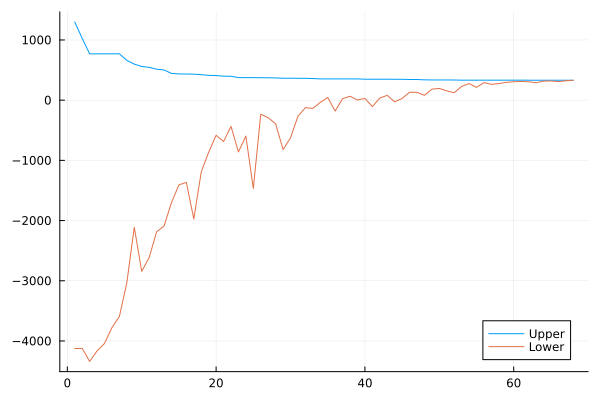

In [153]:
plot(
    1:length(cvrp_solution_large["upper_bounds"]),
    [
        cvrp_solution_large["upper_bounds"],
        cvrp_solution_large["lower_bounds"],
    ],
    legend = :bottomright,
    label = [
        "Upper" "Lower"
    ]
)

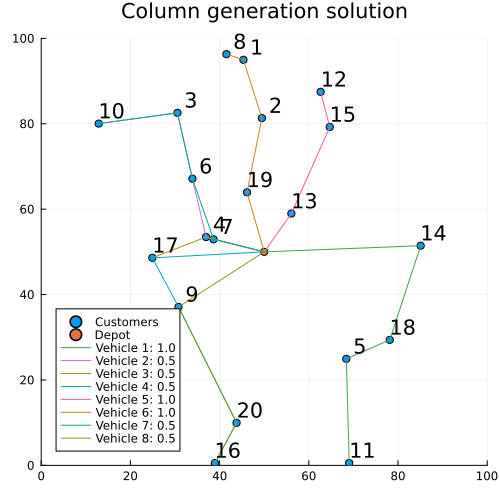

In [154]:
plot_from_route_solution(data_large, cvrp_solution_large["routes"], cvrp_solution_large["CGLP_solution"])
plot!(legend = :bottomleft)

This solution makes sense, but we do observe some funky routes. Recall that all this time, we have been solving the LP relaxation! So we are paying the price of keeping all routes with a nonzero (but possibly fractional) selection variable $x_r$.

### Restoring integrality

In general, when we solve the LP relaxation of the set-partitioning formulation, we might not get an integral solution. There are two cases:
- If we do, great! We know that this integral solution is also optimal for the IP set-partitioning formulation.
- If not, what can we do to restore integrality?

A quick-and-dirty heuristic (which we call "price-and-branch") is to just re-solve the restricted master problem with the columns we have added, while re-introducing integrality.

This heuristic will produce a feasible solution because of the initial routes we've chosen, but in general, it might not find a feasible solution!

Let's implement it for CVRP:

In [157]:
function cvrp_progress_integral(
    data::VehicleRoutingData,
    Q::Int,
    ;
    max_iterations::Int = 10000,
    verbose::Bool = true,
)
    """
    Column generation algorithm for the VRP.
    """
    N = data.num_customers

    # Initialization
    CGLP_solution = nothing
    CGLP_objective = 0.0
    upper_bounds = []
    lower_bounds = []
    MP_time = []
    SP_time = []
    p_values = []

    if verbose
        @printf("              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost\n")
    end

    # Creates initial routes
    routes = initial_routes(data)
    counter = 0

    while true
        counter += 1

        # Make restricted master problem with current routes 
        MP_start_time = time()
        model = Model(() -> Gurobi.Optimizer(GRB_ENV))
        set_optimizer_attributes(
            model,
            "OutputFlag" => 0,
        )
        @variable(model, x[r in 1:length(routes)] ≥ 0)
        @constraint(
            model,
            visit_customer[i in 1:N], 
            sum(
                x[r] for r in 1:length(routes)
                if i in routes[r].customers
            ) == 1
        )
        @objective(
            model, 
            Min,
            sum(x[r] * routes[r].cost for r in 1:length(routes))
        )
        optimize!(model)
        MP_end_time = time() 

        # Get dual values
        p = dual.(visit_customer)
        push!(p_values, p)

        # Update column generation metrics
        push!(upper_bounds, objective_value(model))
        push!(MP_time, MP_end_time - MP_start_time)

        # Compute a new route to add and its corresponding reduced cost
        SP_start_time = time()
        route, reduced_cost = new_route_cap(data, p, Q)
        SP_end_time = time()

        # Update column generation metrics
        push!(lower_bounds, objective_value(model) + N * reduced_cost)
        push!(SP_time, SP_end_time - SP_start_time)

        if verbose
            # @printf("              | Objective | MP time (s) | SP time (s) | Reduced cost")
            @printf(
                "Iteration %3d | %9.3f | %11.3f |      %6.3f |      %6.3f | %12.3f\n",
                counter, 
                upper_bounds[end],
                lower_bounds[end],
                MP_time[end],
                SP_time[end],
                reduced_cost,
            )
        end

        # Termination criteria
        if (
            reduced_cost > -1e-6
            || counter > max_iterations
        )  
            CGLP_solution = value.(x)
            CGLP_objective = objective_value(model)
            break
        end
        push!(routes, route)
    end

    # Solve model again with the same variables, enforcing integrality
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        model,
        "OutputFlag" => 0,
    )
    @variable(model, x[r in 1:length(routes)], Bin)
    @constraint(
        model,
        visit_customer[i in 1:N], 
        sum(
            x[r] for r in 1:length(routes)
            if i in routes[r].customers
        ) == 1
    )
    @objective(
        model, 
        Min,
        sum(x[r] * routes[r].cost for r in 1:length(routes))
    )
    optimize!(model)
    return Dict(
        "CGIP_solution" => value.(x),
        "CGIP_objective" => objective_value(model),
        "CGLP_solution" => CGLP_solution,
        "CGLP_objective" => CGLP_objective,
        "routes" => routes,
        "p_values" => p_values,
        "upper_bounds" => upper_bounds,
        "lower_bounds" => lower_bounds,
        "MP_time" => MP_time,
        "SP_time" => SP_time,
        "time_taken" => sum(MP_time) + sum(SP_time),
    )
end

cvrp_progress_integral (generic function with 1 method)

In [158]:
cvrp_solution_large = cvrp_progress_integral(data_large, 4)
;

              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost
Iteration   1 |  1298.294 |   -4126.832 |       0.021 |       0.067 |     -271.256
Iteration   2 |  1027.037 |   -4122.909 |       0.000 |       0.078 |     -257.497
Iteration   3 |   769.540 |   -4339.987 |       0.001 |       0.064 |     -255.476
Iteration   4 |   769.540 |   -4165.303 |       0.001 |       0.068 |     -246.742
Iteration   5 |   769.540 |   -4041.342 |       0.001 |       0.057 |     -240.544
Iteration   6 |   769.540 |   -3776.822 |       0.003 |       0.114 |     -227.318
Iteration   7 |   769.540 |   -3594.590 |       0.001 |       0.019 |     -218.207
Iteration   8 |   660.437 |   -3032.400 |       0.001 |       0.005 |     -184.642
Iteration   9 |   598.890 |   -2110.398 |       0.000 |       0.022 |     -135.464
Iteration  10 |   558.908 |   -2844.773 |       0.001 |       0.012 |     -170.184
Iteration  11 |   545.200 |   -2614.418 |       0.000 |       0.011 |     -157.981
Iter

Let's report some metrics of the solutions we found:

In [167]:
println("Objective value (Fractional solution): ", cvrp_solution_large["CGLP_objective"])
println("Objective value (Integer solution):    ", cvrp_solution_large["CGIP_objective"])
println("Optimality gap:                        ", (cvrp_solution_large["CGIP_objective"] - cvrp_solution_large["CGLP_objective"]) /  cvrp_solution_large["CGLP_objective"])
println("Time taken:                            ", cvrp_solution_large["time_taken"])

Objective value (Fractional solution): 330.41278317640524
Objective value (Integer solution):    348.46964258134284
Optimality gap:                        0.054649397130912936
Time taken:                            3.3929998874664307


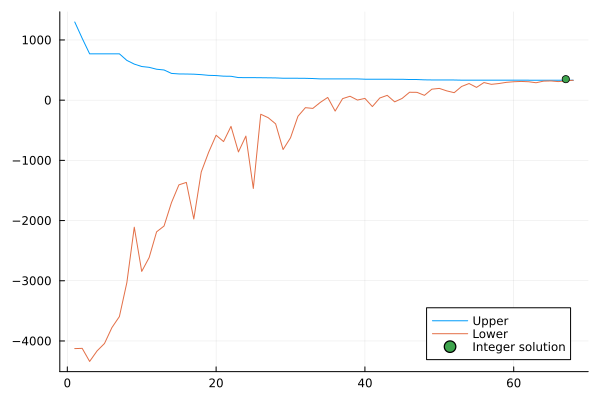

In [168]:
plot(
    1:length(cvrp_solution_large["upper_bounds"]),
    [
        cvrp_solution_large["upper_bounds"],
        cvrp_solution_large["lower_bounds"],
    ],
    legend = :bottomright,
    label = [
        "Upper" "Lower"
    ]
)
scatter!(
    [length(cvrp_solution_large["upper_bounds"]) - 1], 
    [cvrp_solution_large["CGIP_objective"]], 
    label="Integer solution"
)

It looks like the heuristic worked really well! Let's look at the solutions:

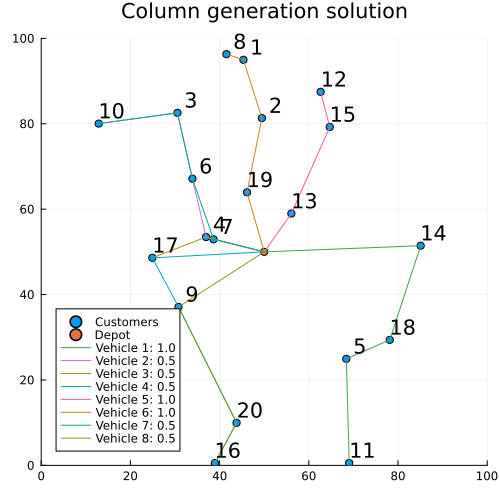

In [161]:
plot_from_route_solution(
    data_large,
    cvrp_solution_large["routes"],
    cvrp_solution_large["CGLP_solution"],
)
plot!(legend = :bottomleft)

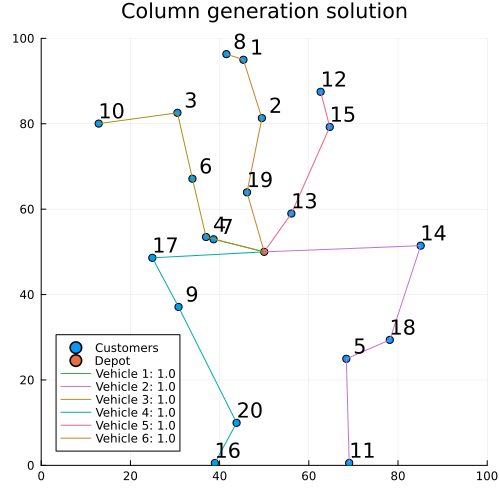

In [162]:
plot_from_route_solution(
    data_large,
    cvrp_solution_large["routes"],
    cvrp_solution_large["CGIP_solution"],
)
plot!(legend = :bottomleft)